# PCA from several perspectives
- geometric (intuition)
- mathematical
- statistical

In [1]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from numpy.linalg import eig, svd
from scipy.stats import pearsonr
from seaborn import heatmap

# PCA: intuition

In [2]:
# get data
cars = pd.read_excel('cars1989.xlsx', sheet_name='carselect')
cars.set_index('car', inplace=True)

# color scheme for each car
tableau20 = {'purple': '#9467bd',
             'blue'  : '#1f77b4',
             'green' : '#2ca02c',
             'red'   : '#d62728',
             'brown' : '#8c564b'
}
cars['rgb'] = cars.color.map(lambda x: tableau20[x])

# standardize data
numericals = ['length', 'width']
carsm = (cars[numericals] - cars.mean()) / cars.std()

# perform pca calculations
covariance = np.cov(carsm.T)
evals, evecs = eig(covariance)
largest_evec = evecs[:, 0]
slope = largest_evec[1] / largest_evec[0]
factor_scores = carsm @ evecs

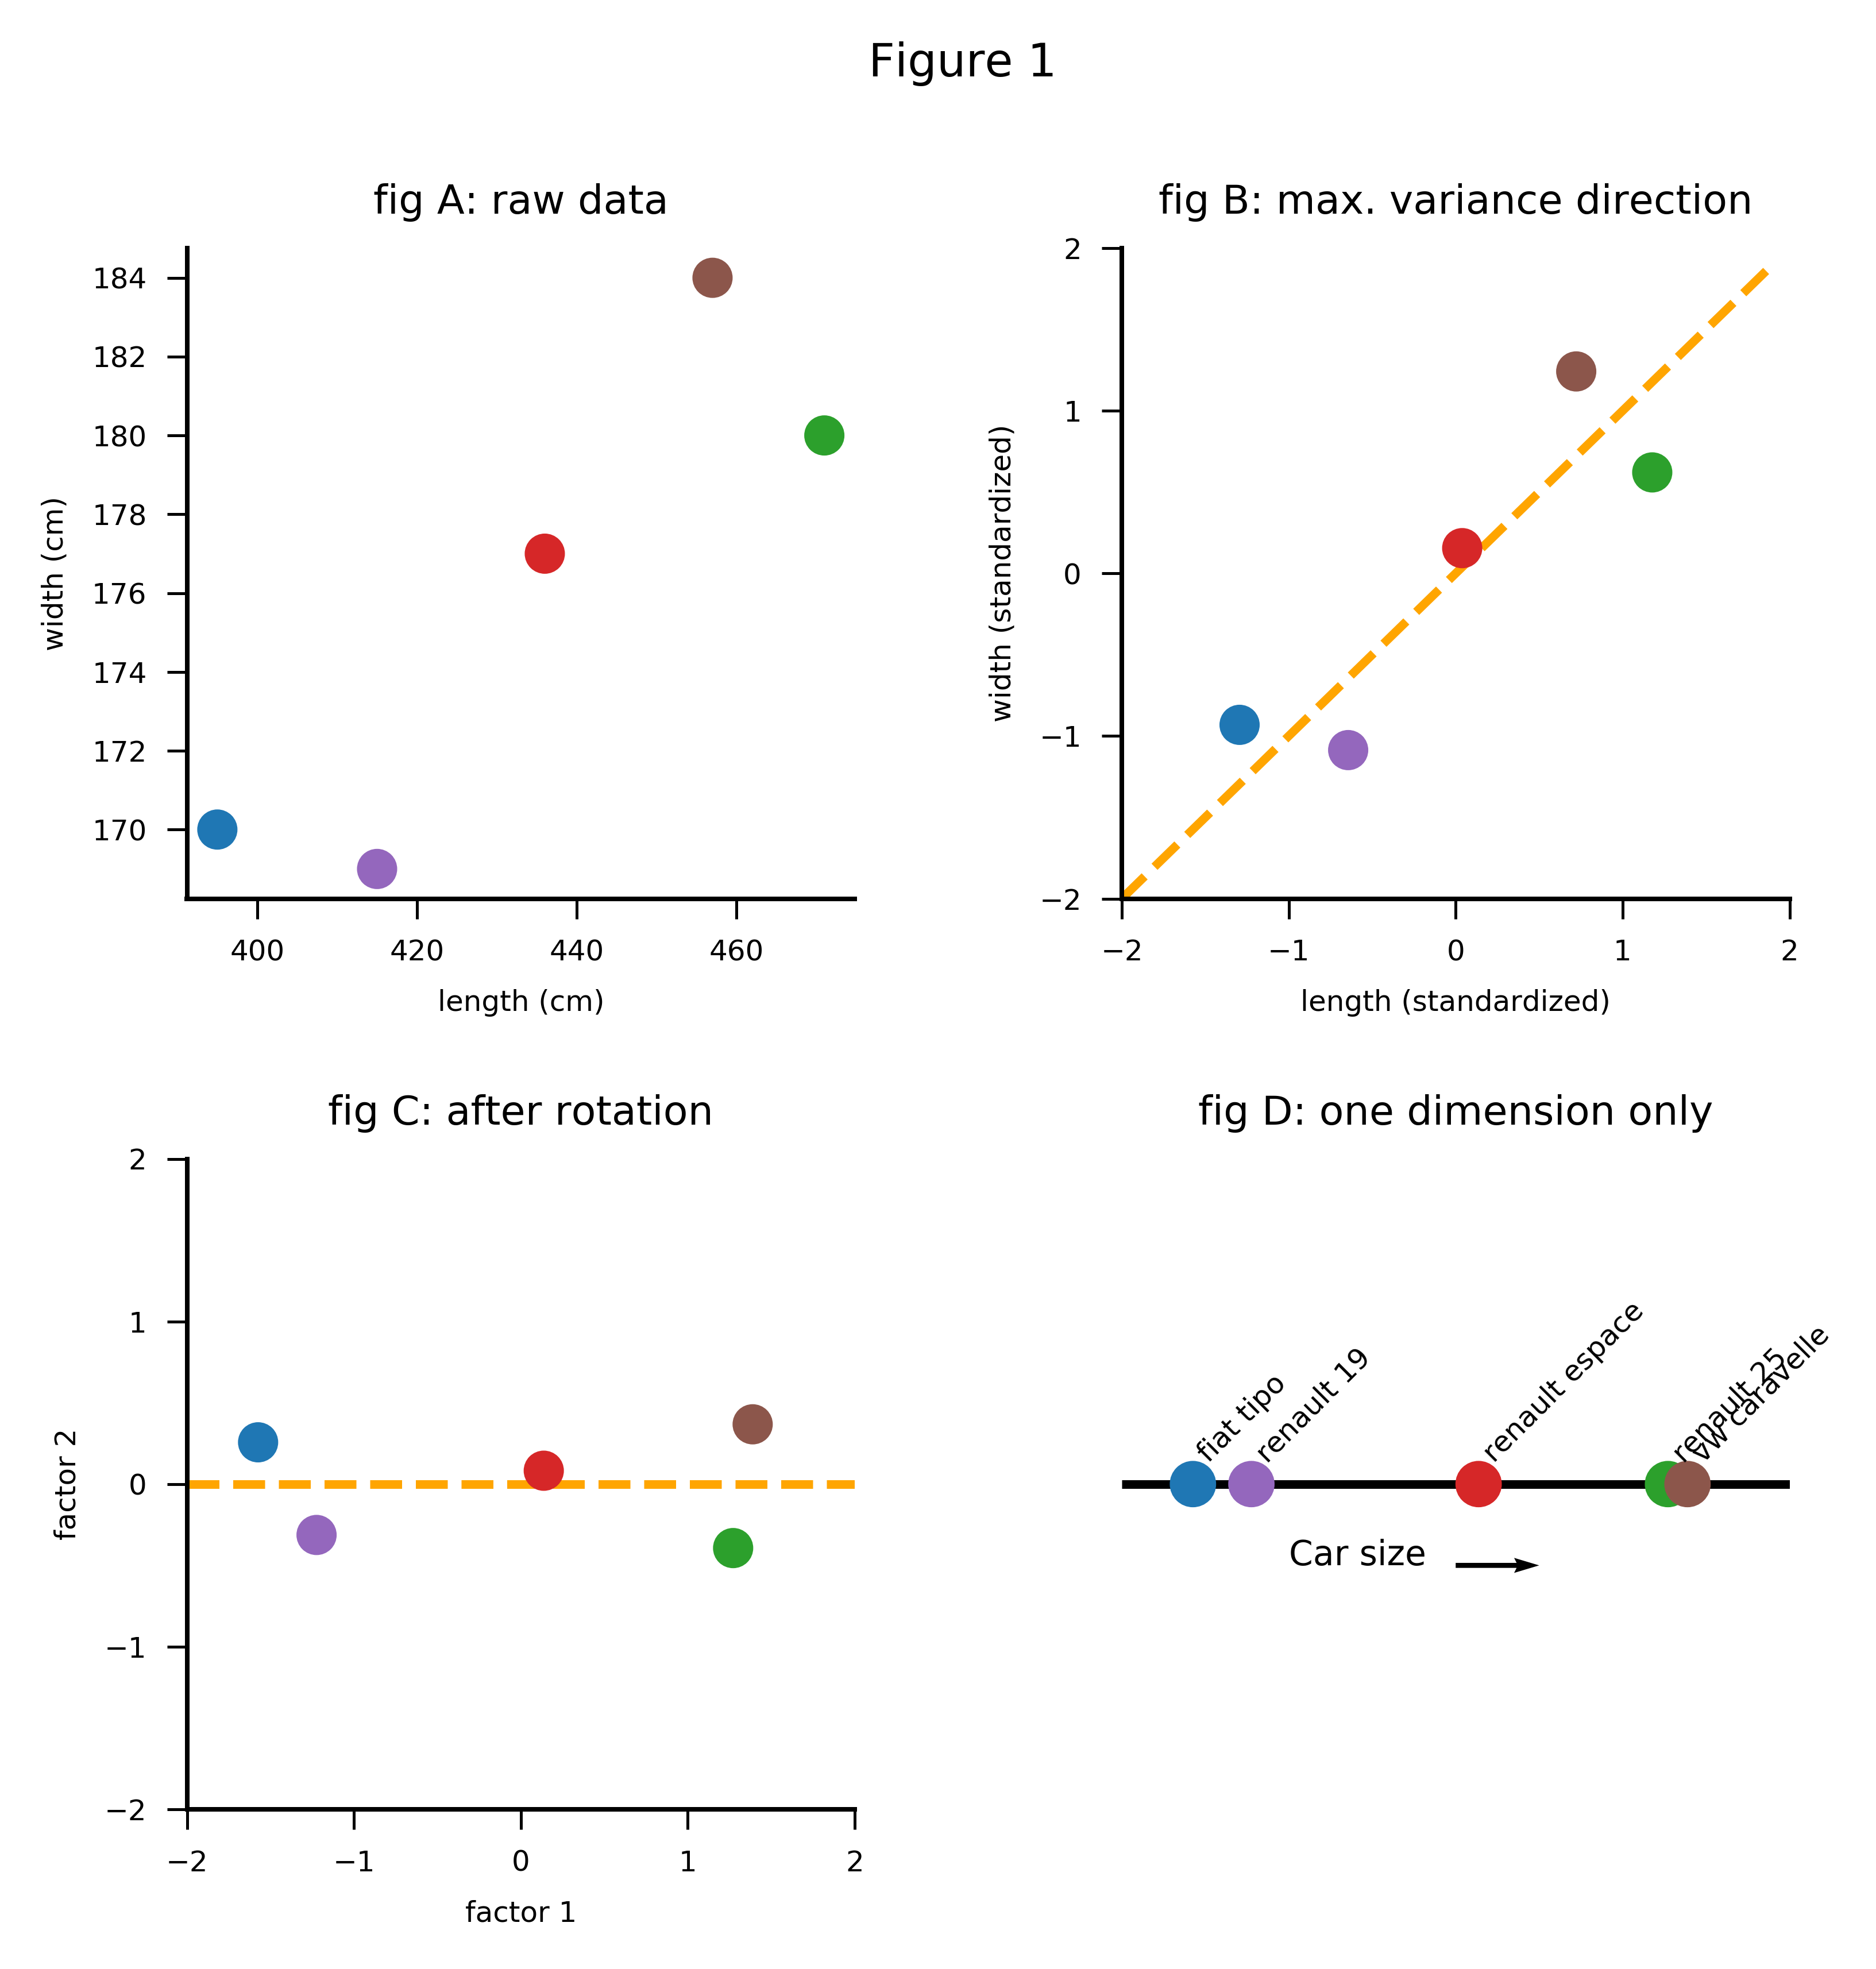

In [3]:
# create plots
fig, ax = plt.subplots(2, 2, figsize=(5,5))
fig.set_dpi(720)
fig.subplots_adjust(wspace=0.4, hspace=0.4)
plt.suptitle('Figure 1', fontsize=8)

TITLE_SIZE = 7
LABEL_SIZE = 5

# settings for all axis
for i in range(2):
    for j in range(2):
        ax[i][j].tick_params(axis='both', which='major', labelsize=LABEL_SIZE)
        ax[i][j].set_xlabel(xlabel='', fontsize=LABEL_SIZE)
        ax[i][j].set_ylabel(ylabel='', fontsize=LABEL_SIZE)
        ax[i][j].tick_params(width=0.5)
        ax[i][j].spines['right'].set_visible(False)
        ax[i][j].spines['top'].set_visible(False)
        
# plot A: raw data
xy = ax[0][0]  
xy.scatter(cars.length, cars.width, color=cars.rgb)
xy.set_xlabel('length (cm)')
xy.set_ylabel('width (cm)')
xy.set_title('fig A: raw data', size=TITLE_SIZE)

# plot B: direction of highest variance on standardized features
xy = ax[0][1]
stand_range = np.array([-2, 2])
xrange = np.arange(*stand_range, 0.1)
xy.set_xlim(*stand_range)
xy.set_ylim(*stand_range)
xy.yaxis.set_ticks(np.arange(-2, 2+1, 1))
xy.scatter(carsm['length'], carsm['width'], color=cars.rgb, zorder=1)
xy.plot(xrange, slope * xrange, linestyle='--', color='orange', zorder=-1)
xy.set_xlabel('length (standardized)')
xy.set_ylabel('width (standardized)')
xy.set_title('fig B: max. variance direction', size=TITLE_SIZE)

# plot C: rotate largest eigenvector to x-axes
xy = ax[1][0]
xy.set_xlim(*stand_range)
xy.set_ylim(*stand_range)
xy.yaxis.set_ticks(np.arange(-2, 2+1, 1))
xy.scatter(factor_scores[0], factor_scores[1], color=cars.rgb, zorder=1)
xy.axhline(0, linestyle='--', color='orange', zorder=-1)
xy.set_xlabel('factor 1')
xy.set_ylabel('factor 2')
xy.set_title('fig C: after rotation', size=TITLE_SIZE)

# plot D: cars by size
xy = ax[1][1]
xy.axis('off')
xy.hlines(y=0, xmin=stand_range[0], xmax=stand_range[1], zorder=-1)
xy.scatter(y=np.zeros(5), x=factor_scores[0], color=cars.rgb, s=50, zorder=1)
xy.set_xlim(*stand_range)
xy.set_ylim(*stand_range)
points = list(zip(factor_scores[0], np.ones(5)/10))
labels = list(factor_scores.index)
_ = [xy.annotate(lab, location, rotation=45,
                       verticalalignment='left', size=5)
     for lab, location in zip(labels, points)]
xy.set_title('fig D: one dimension only', size=TITLE_SIZE)
_ = xy.quiver(0, -0.5, 0.5, 0, angles='xy', scale_units='xy', scale=1)
_ = xy.annotate('Car size', (-1, -0.5), size=6)
# fig.savefig('/home/pieter/Desktop/pca_post/intuition.png')

# PCA: math

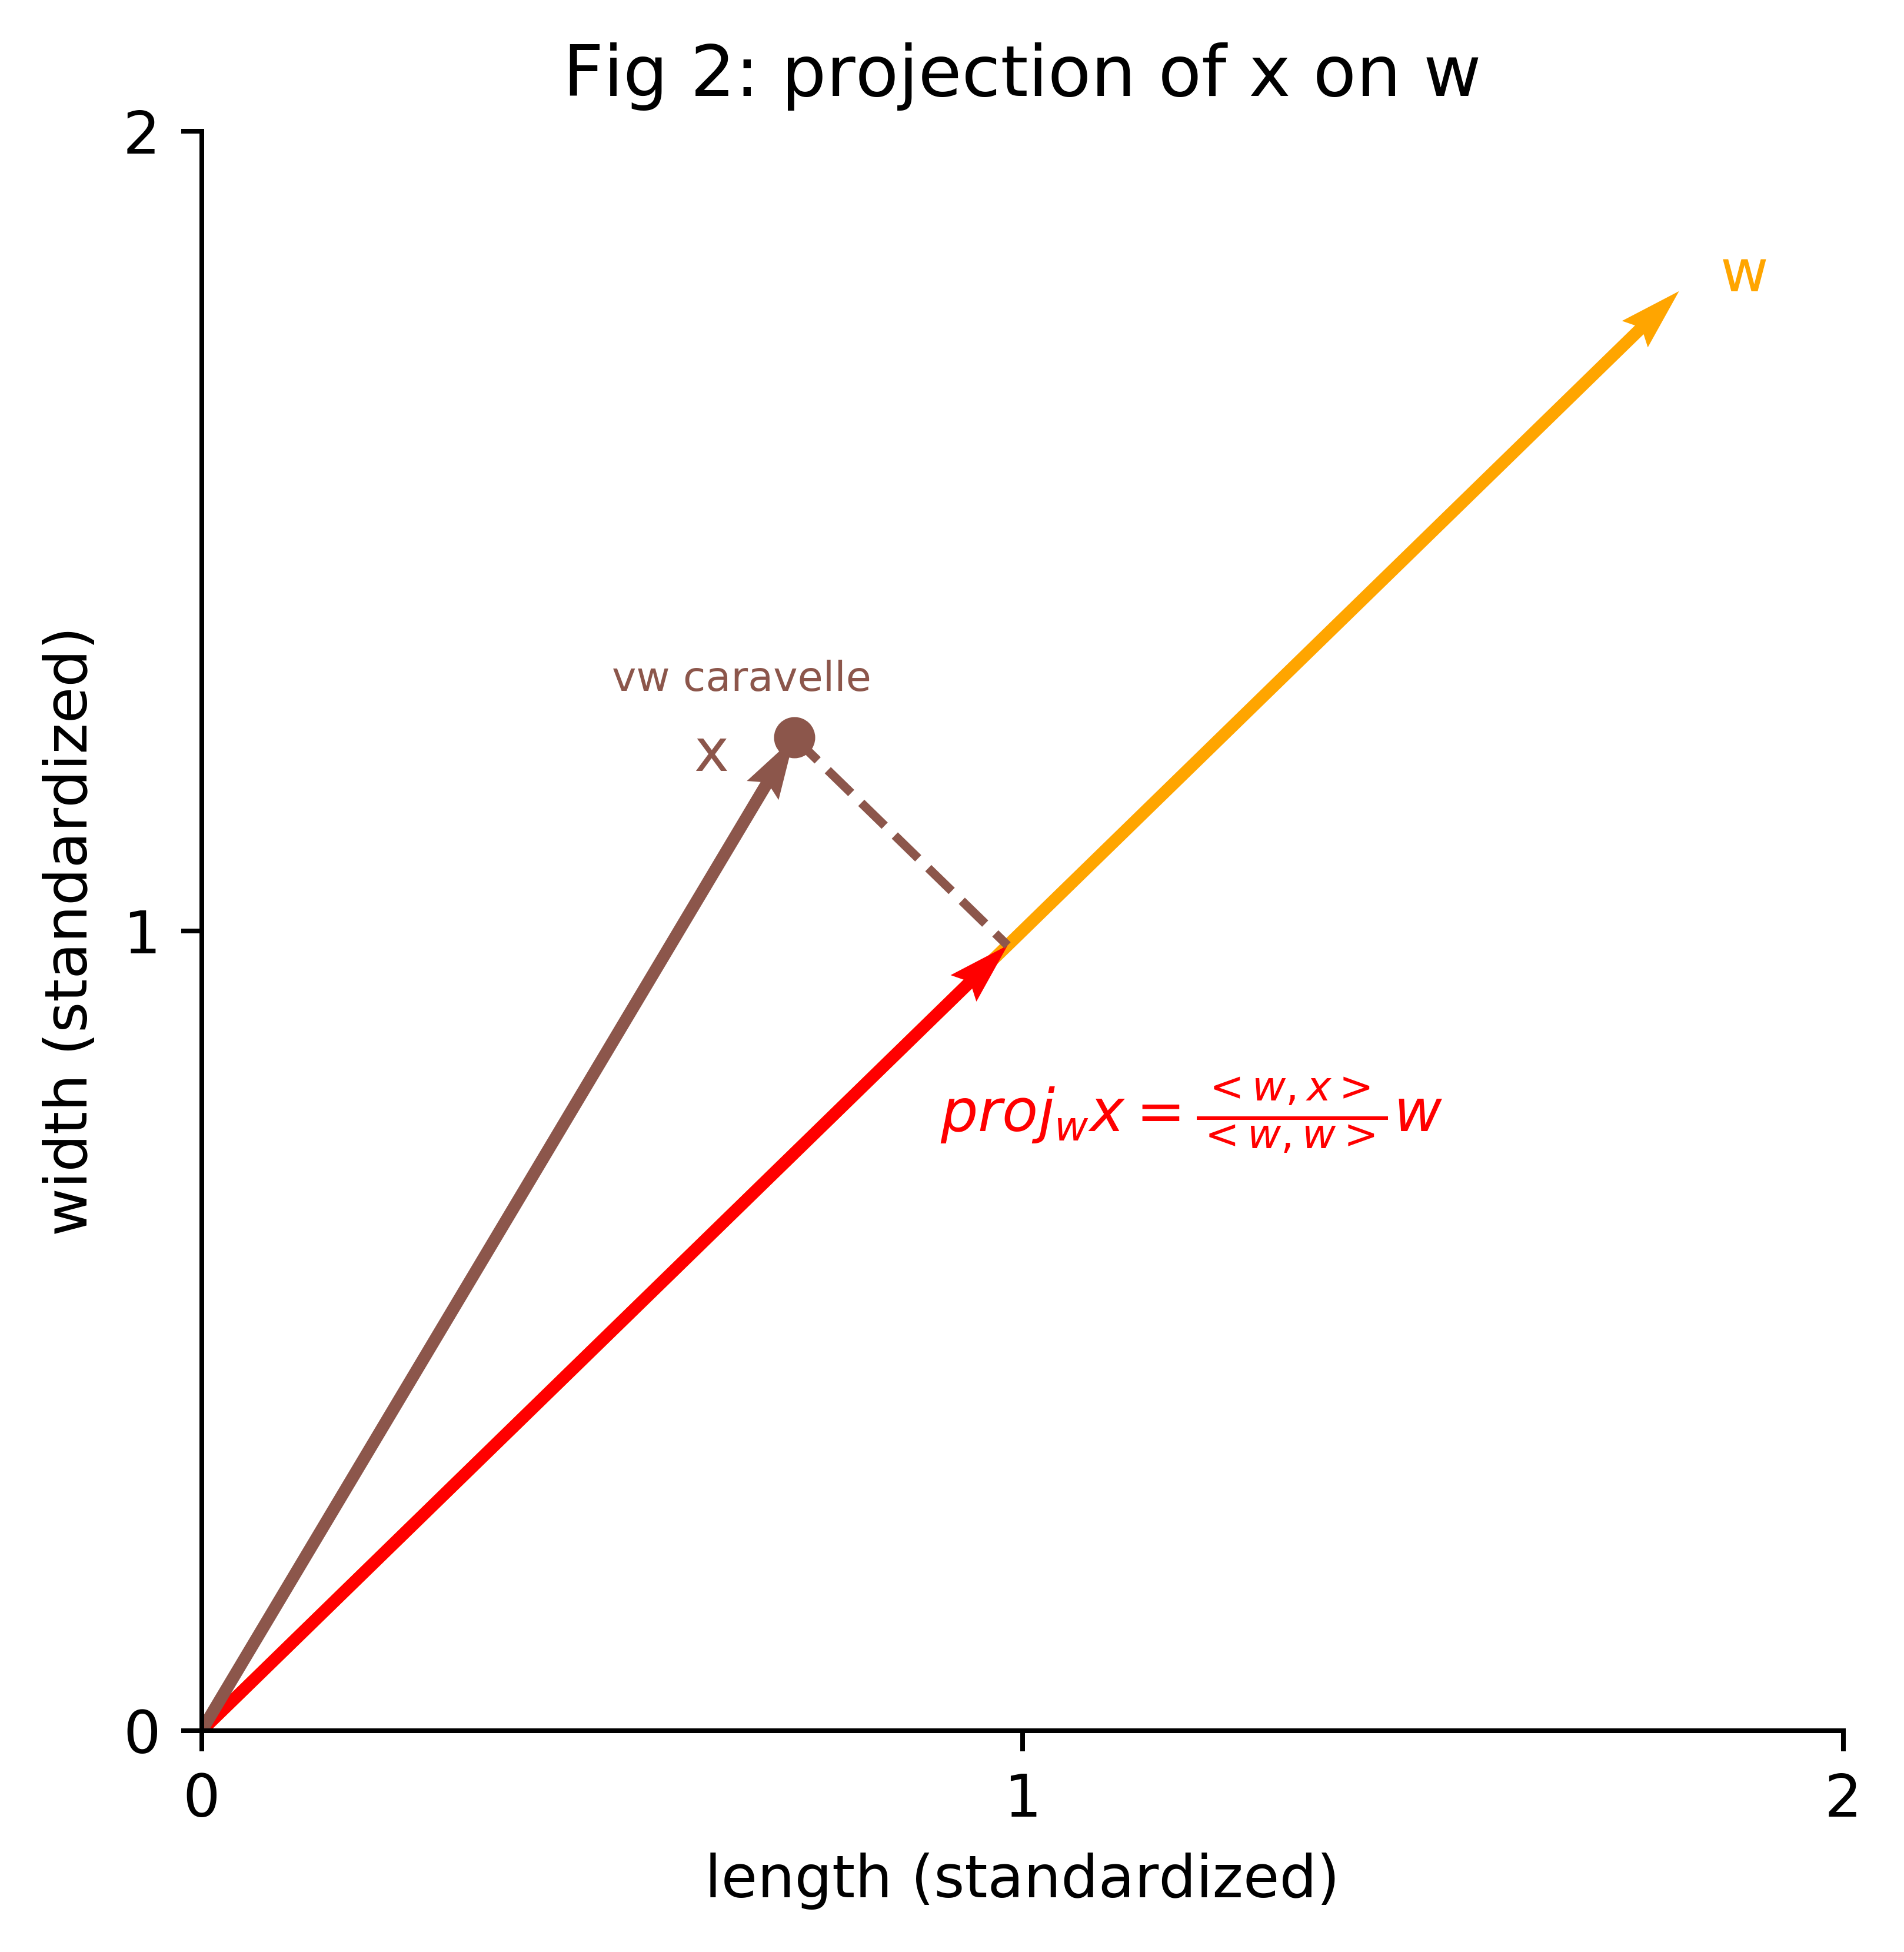

In [4]:
# The *vector projection of b onto a* is the vector with this length
# that begins at the point A points in the same direction
# (or opposite direction if the scalar projection is negative) as a. 

sample = 'vw caravelle'

a = np.array([2, 2 * slope])
b = carsm.loc[sample].values
col = cars.loc[sample]['rgb']

fig, ax = plt.subplots(figsize=(5,5))
fig.set_dpi(720)
ax.scatter(x=b[0], y=b[1], color=col)
projection = a @ b / np.inner(a, a)
projection_vector = projection * a
ax.plot([b[0], projection_vector[0]],
        [b[1], projection_vector[1]],
            linestyle='--', color=col)
_ = ax.annotate(sample, (0.5, 1.3), color=col, size=7)
xrange = np.array([0, 2])

vector_length = 1.8
ax.quiver(0, 0, vector_length, vector_length * slope,
          angles='xy', scale_units='xy', scale=1, color='orange')
_ = ax.annotate('w', (1.85, 1.8), color='orange')

ax.quiver(0, 0, projection_vector[0], projection_vector[1],
          angles='xy', scale_units='xy', scale=1, color='red')
_ = ax.annotate(r'$proj_wx=\frac{<w, x>} {<w, w>}w$', (0.9, 0.75), color='red')

ax.quiver(0, 0, b[0], b[1],
          angles='xy', scale_units='xy', scale=1, color=col)
_ = ax.annotate('x', (0.6, 1.2), color=col)

ax.set_xlim(0, 2)
ax.set_ylim(0, 2)
_ = ax.xaxis.set_ticks(np.arange(0, 2+1, 1))
_ = ax.yaxis.set_ticks(np.arange(0, 2+1, 1))
ax.set_xlabel('length (standardized)')
ax.set_ylabel('width (standardized)')
ax.set_title('Fig 2: projection of x on w')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# fig.savefig('/home/pieter/Desktop/pca_post/projection.png')

# Cars example

In [5]:
# get data
cars = pd.read_excel('cars1989.xlsx', sheet_name='cars')
cars.set_index('car', inplace=True)

In [6]:
# summary stats
ncars, nvariables = cars.shape
cars.describe().T

,count,mean,std,min,25%,50%,75%,max
engine,24.0,1906.125000,527.908697,1116.0,1550.25,1928.5,2078.25,2986.0
power,24.0,113.666667,38.784428,50.0,89.50,101.5,131.25,188.0
speed,24.0,183.083333,25.215448,135.0,173.00,181.5,195.50,226.0
weight,24.0,1110.833333,230.291246,730.0,913.75,1127.5,1305.00,1510.0
length,24.0,421.583333,41.340491,350.0,370.75,436.0,452.50,473.0
width,24.0,168.833333,7.653738,155.0,163.50,169.0,175.00,184.0


In [7]:
# correlation matrix
correlations = cars.corr()
correlations

,engine,power,speed,weight,length,width
engine,1.000000,0.860976,0.693315,0.904934,0.864202,0.709059
power,0.860976,1.000000,0.893987,0.746079,0.688515,0.552280
speed,0.693315,0.893987,1.000000,0.491420,0.531908,0.363234
weight,0.904934,0.746079,0.491420,1.000000,0.917112,0.790915
length,0.864202,0.688515,0.531908,0.917112,1.000000,0.863814
width,0.709059,0.552280,0.363234,0.790915,0.863814,1.000000


In [8]:
# correlation matrix (the hard way)
standardized = (cars - cars.mean()) / cars.std()
ncars = len(standardized)
standardized.T @ standardized / (ncars - 1)

,engine,power,speed,weight,length,width
engine,1.000000,0.860976,0.693315,0.904934,0.864202,0.709059
power,0.860976,1.000000,0.893987,0.746079,0.688515,0.552280
speed,0.693315,0.893987,1.000000,0.491420,0.531908,0.363234
weight,0.904934,0.746079,0.491420,1.000000,0.917112,0.790915
length,0.864202,0.688515,0.531908,0.917112,1.000000,0.863814
width,0.709059,0.552280,0.363234,0.790915,0.863814,1.000000


In [9]:
# which correlations are significant?
pvalues = [[pearsonr(cars.iloc[:,i], cars.iloc[:,j])[1] 
                for j in range(nvariables)]
                for i in range(nvariables)]
pvalues = pd.DataFrame(pvalues, index=cars.columns, columns=cars.columns)
is_significant = (pvalues < 0.005)
is_significant

,engine,power,speed,weight,length,width
engine,True,True,True,True,True,True
power,True,True,True,True,True,False
speed,True,True,True,False,False,False
weight,True,True,False,True,True,True
length,True,True,False,True,True,True
width,True,False,False,True,True,True


In [10]:
# eigenvalues
eigvals, eigvecs = eig(correlations)
pca = cars @ eigvecs

In [11]:
# eigenvalues 
evals = pd.DataFrame({'eigvalues': sorted(eigvals, reverse=True)})
evals['pct_variance'] = 100 * evals.eigvalues / sum(evals.eigvalues)
evals['cum_variance'] = evals.pct_variance.cumsum()
evals.T

,0,1,2,3,4,5
eigvalues,4.656021,0.915221,0.240431,0.102710,0.064656,0.020961
pct_variance,77.600354,15.253691,4.007177,1.711825,1.077604,0.349348
cum_variance,77.600354,92.854045,96.861222,98.573047,99.650652,100.000000


In [12]:
# check eigenvectors have each norm=1
(pd.DataFrame(eigvecs).T * pd.DataFrame(eigvecs).T).sum()

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
dtype: float64

In [13]:
# eigenvectors add up to number of variables
sum(eigvals)

6.000000000000001

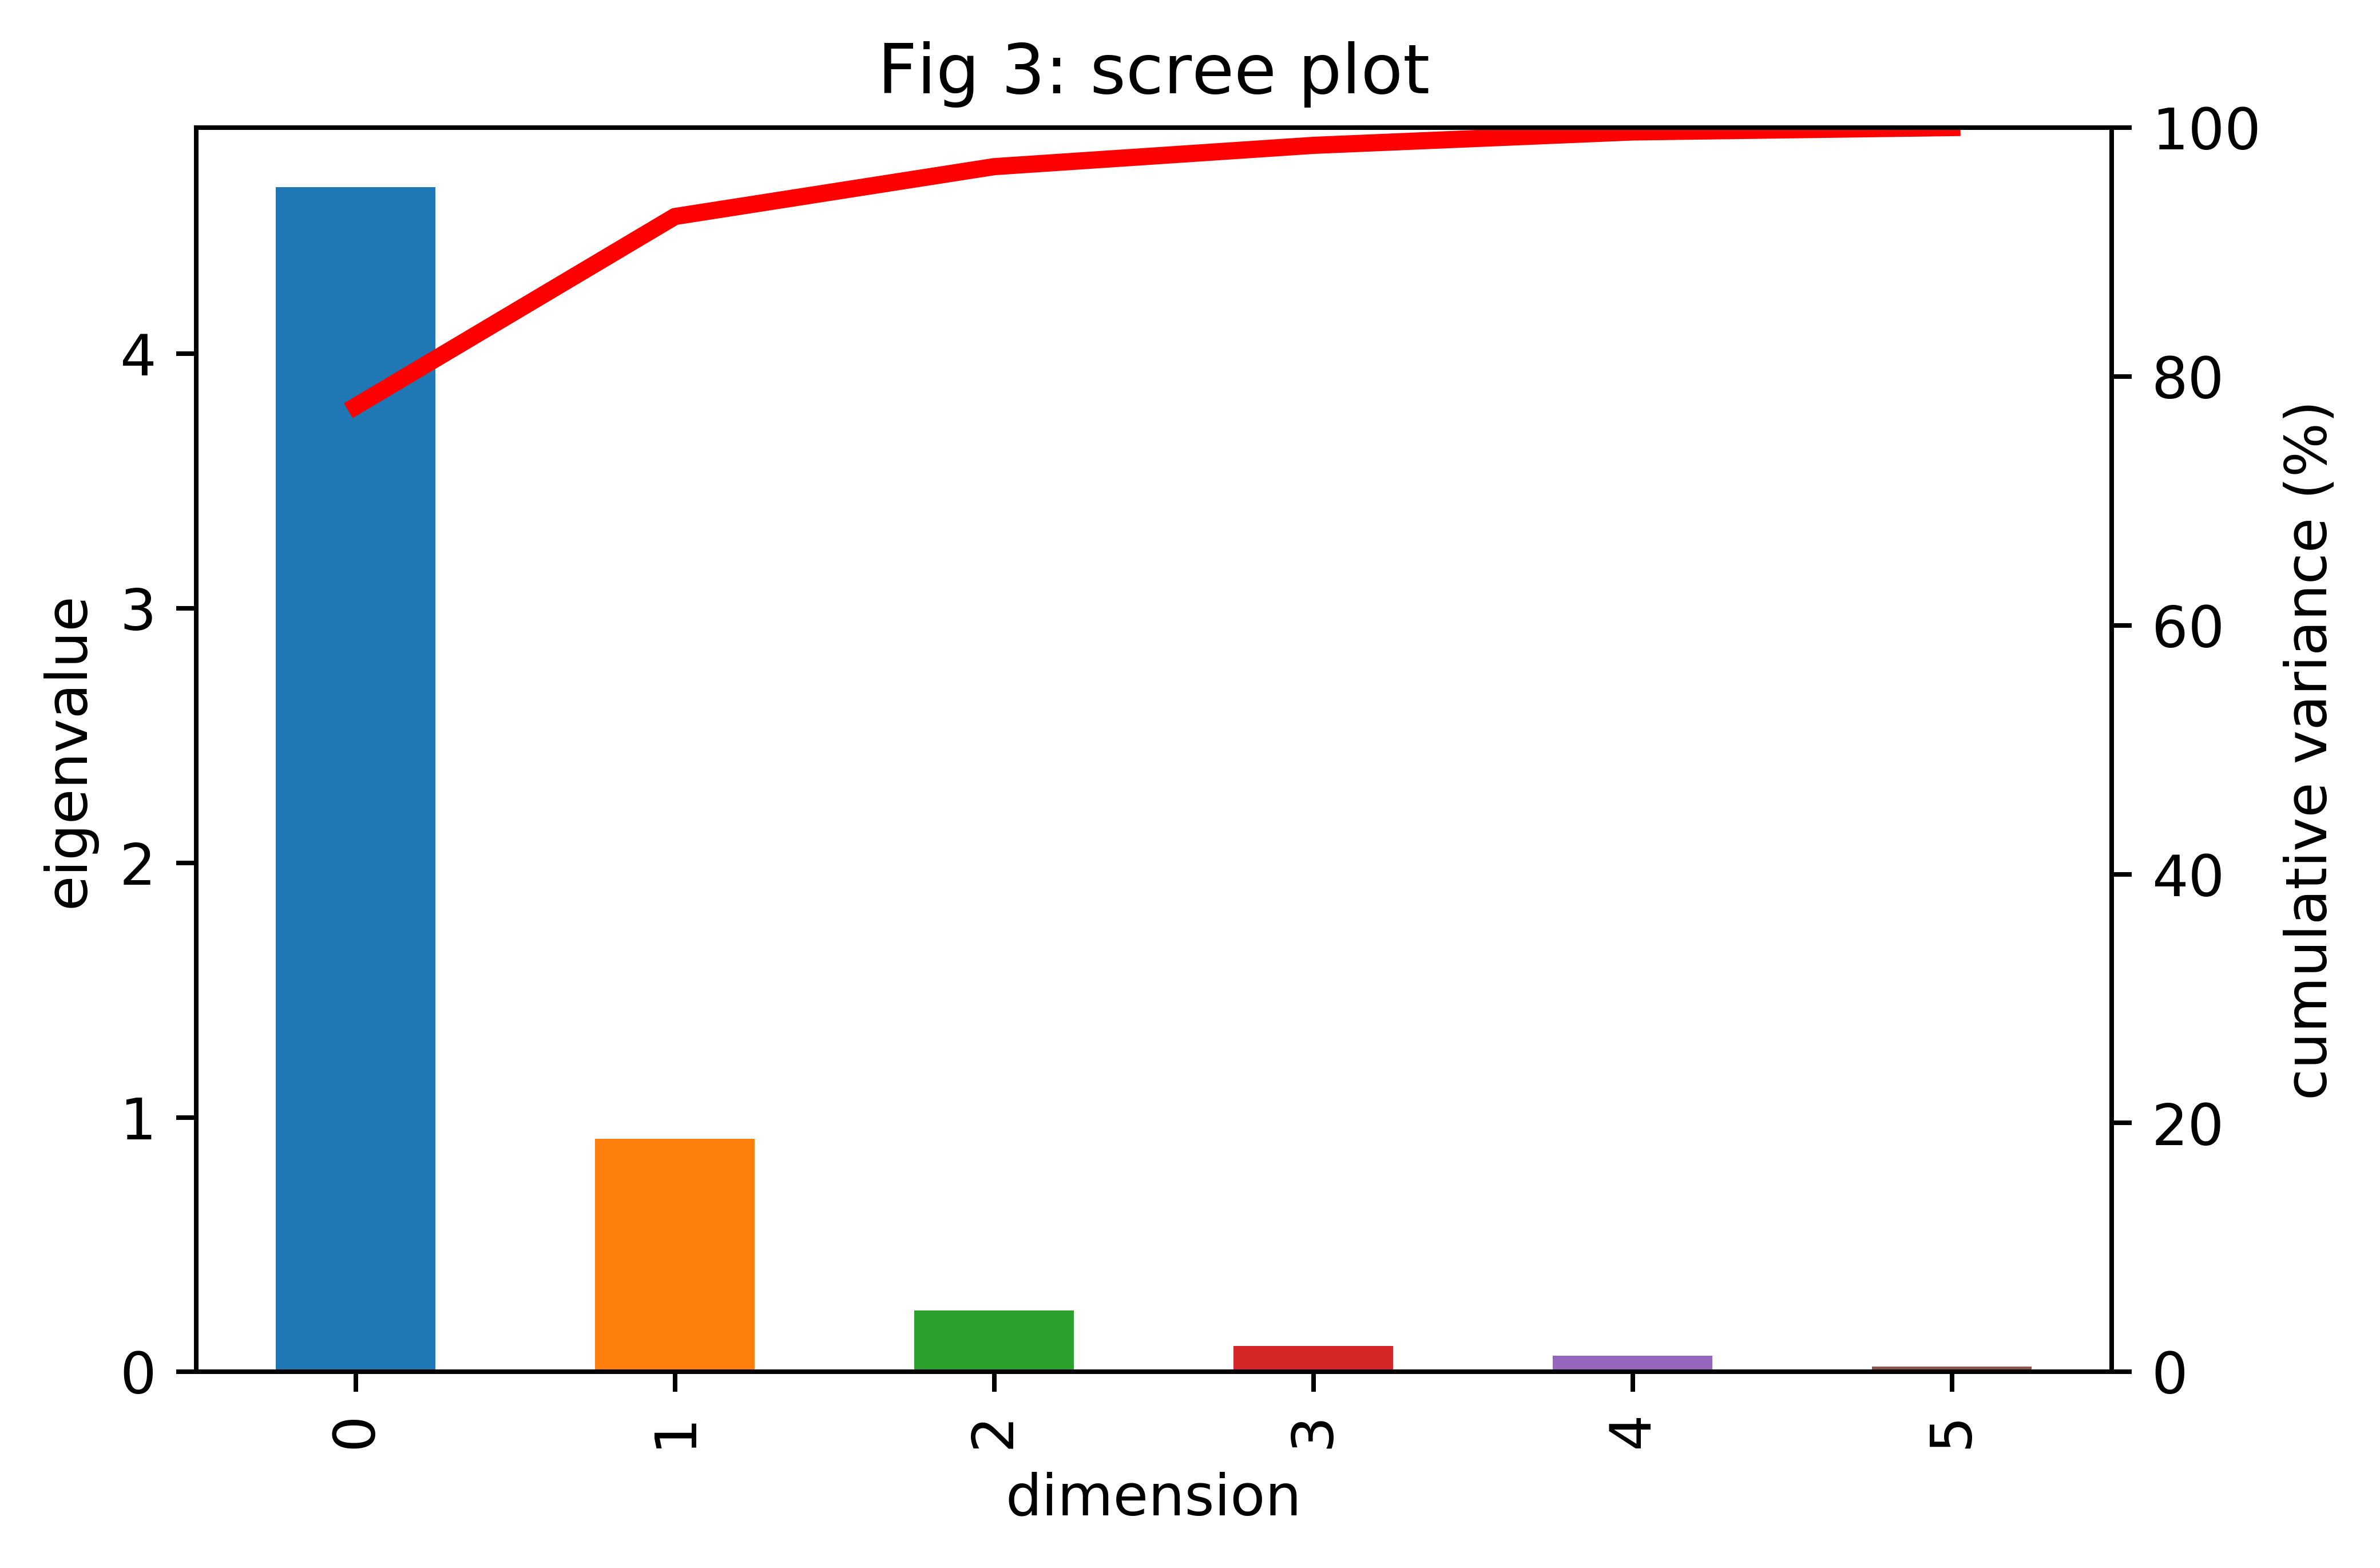

In [14]:
# scree plot: two components are sufficient to explain this dataset
fig, ax = plt.subplots()
fig.set_dpi(720)
ax2 = ax.twinx()
evals.eigvalues.plot(kind='bar', ax=ax)
evals.cum_variance.plot(kind='line', ax=ax2, color='red', linewidth=3)
ax.set_xlabel('dimension')
ax.set_ylabel('eigenvalue')
ax2.set_ylim(0, 100)
ax2.set_ylabel('cumulative variance (%)')
ax.set_title('Fig 3: scree plot')
# fig.savefig('/home/pieter/Desktop/pca_post/scree_plot.png')

In [15]:
# eigenvectors
# all variables have a positive contribution to factor 1 but not to factor 2
evecs = pd.DataFrame(eigvecs, index=correlations.index)
evecs

,0,1,2,3,4,5
engine,0.444202,0.033964,-0.401432,-0.798600,0.050025,0.010863
power,0.414490,0.421222,-0.039561,0.306665,0.489717,0.561550
speed,0.343540,0.663436,0.369935,0.007185,-0.319909,-0.450097
weight,0.430321,-0.255169,-0.484461,0.472589,0.123152,-0.525836
length,0.430209,-0.295584,0.043984,0.165972,-0.711849,0.437425
width,0.377633,-0.478319,0.681027,-0.131360,0.365291,-0.118797


In [16]:
# yes the eigenvectors are orthogonal and have norm=1
(evecs.T @ evecs).applymap(lambda x: round(x, 10))

,0,1,2,3,4,5
0,1.0,0.0,0.0,0.0,0.0,-0.0
1,0.0,1.0,0.0,0.0,-0.0,-0.0
2,0.0,0.0,1.0,-0.0,-0.0,-0.0
3,0.0,0.0,-0.0,1.0,0.0,-0.0
4,0.0,-0.0,-0.0,0.0,1.0,-0.0
5,-0.0,-0.0,-0.0,-0.0,-0.0,1.0


In [17]:
# factor loadings (=correlations between factors and variables)
factors = standardized @ evecs
factors_standardized = (factors - factors.mean()) / factors.std()
loadings = standardized.T @ factors_standardized / (ncars - 1)
loadings

,0,1,2,3,4,5
engine,0.958491,0.032493,-0.196837,-0.203065,0.016032,0.001573
power,0.894380,0.402972,-0.019398,0.077978,0.156946,0.081301
speed,0.741285,0.634691,0.181393,0.001827,-0.102526,-0.065164
weight,0.928539,-0.244113,-0.237549,0.120168,0.039468,-0.076130
length,0.928297,-0.282777,0.021567,0.042203,-0.228136,0.063330
width,0.814849,-0.457595,0.333933,-0.033402,0.117070,-0.017199


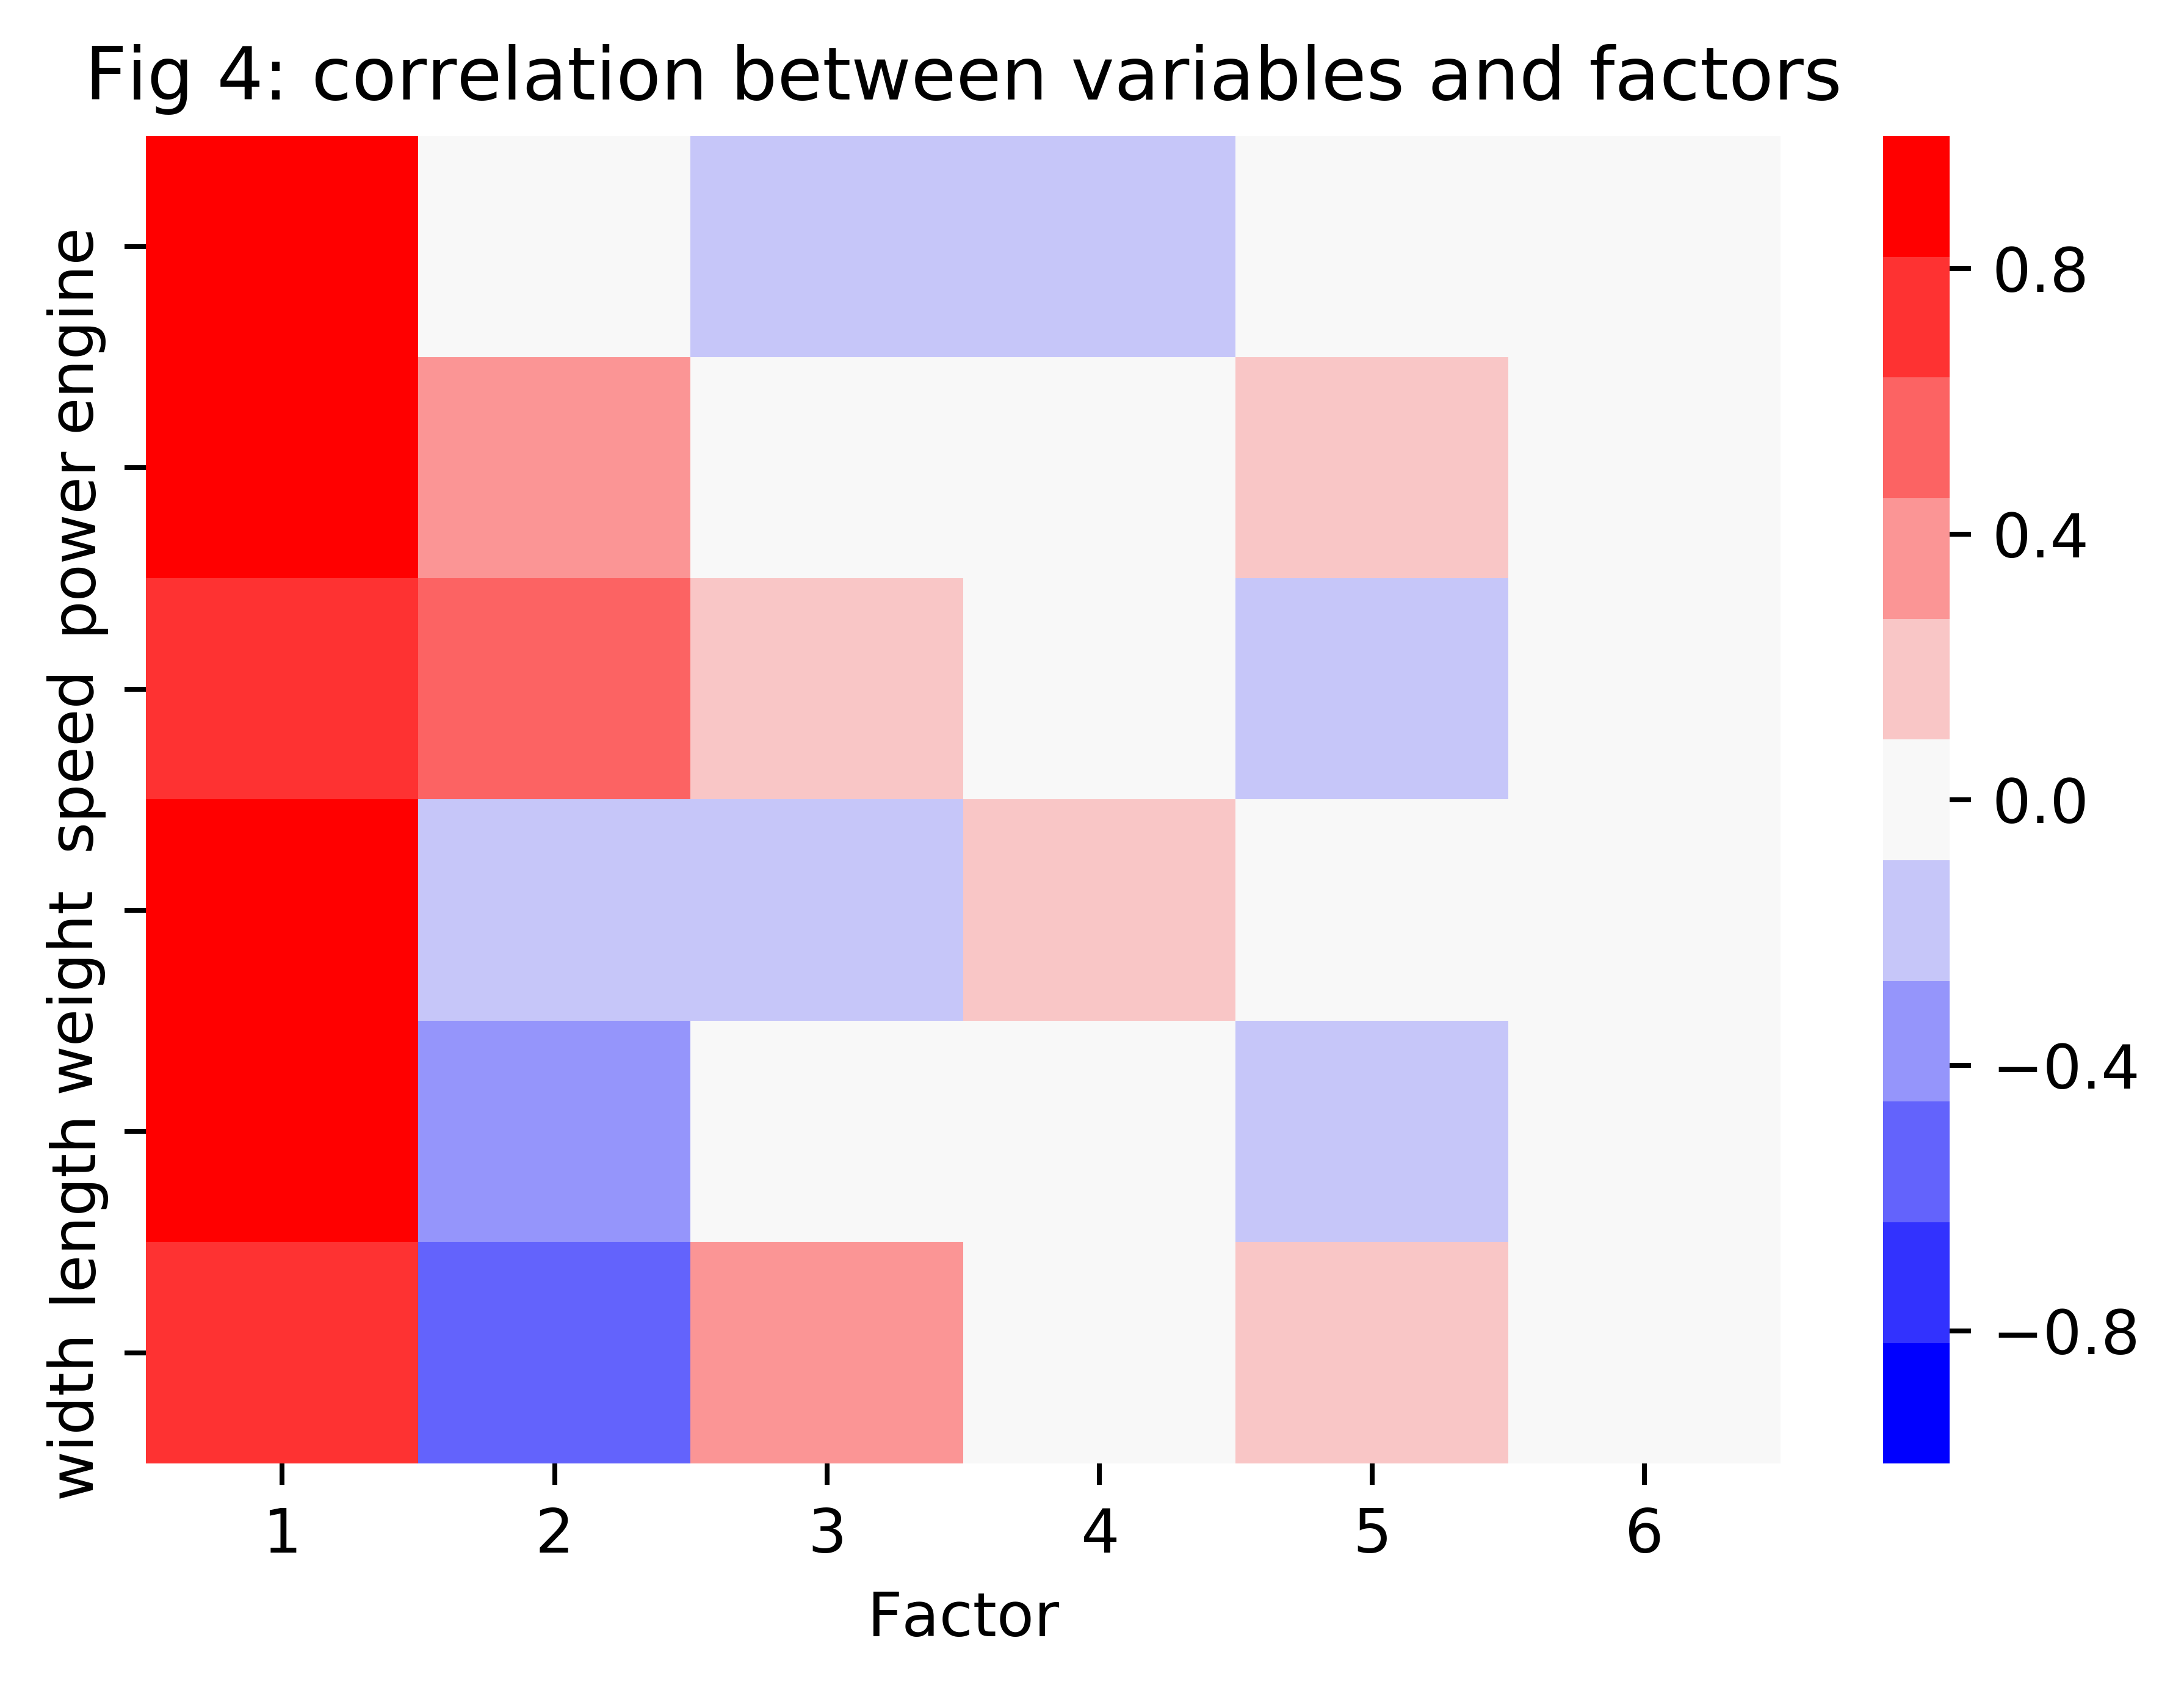

In [18]:
def custom_div_cmap(numcolors=11, name='custom_div_cmap',
                    mincol='blue', midcol='white', maxcol='red'):
    """ Create a custom diverging colormap with three colors
    
    Default is blue to white to red with 11 colors.  Colors can be specified
    in any way understandable by matplotlib.colors.ColorConverter.to_rgb()
    
    Credits: http://pyhogs.github.io/colormap-examples.html
    """

    from matplotlib.colors import LinearSegmentedColormap 
    
    cmap = LinearSegmentedColormap.from_list(name=name, 
                                             colors =[mincol, midcol, maxcol],
                                             N=numcolors)
    return cmap

custom_map = custom_div_cmap(11, mincol='blue', midcol='#F8F8F8' ,maxcol='red')
fig, ax = plt.subplots()
fig.set_dpi(720)
heatmap(loadings, cmap=custom_map, ax=ax, vmin=-1, vmax=1,
        xticklabels=range(1, 7))
ax.set_title('Fig 4: correlation between variables and factors')
ax.set_xlabel('Factor')
# fig.savefig('/home/pieter/Desktop/pca_post/correlations_heatmap.png')

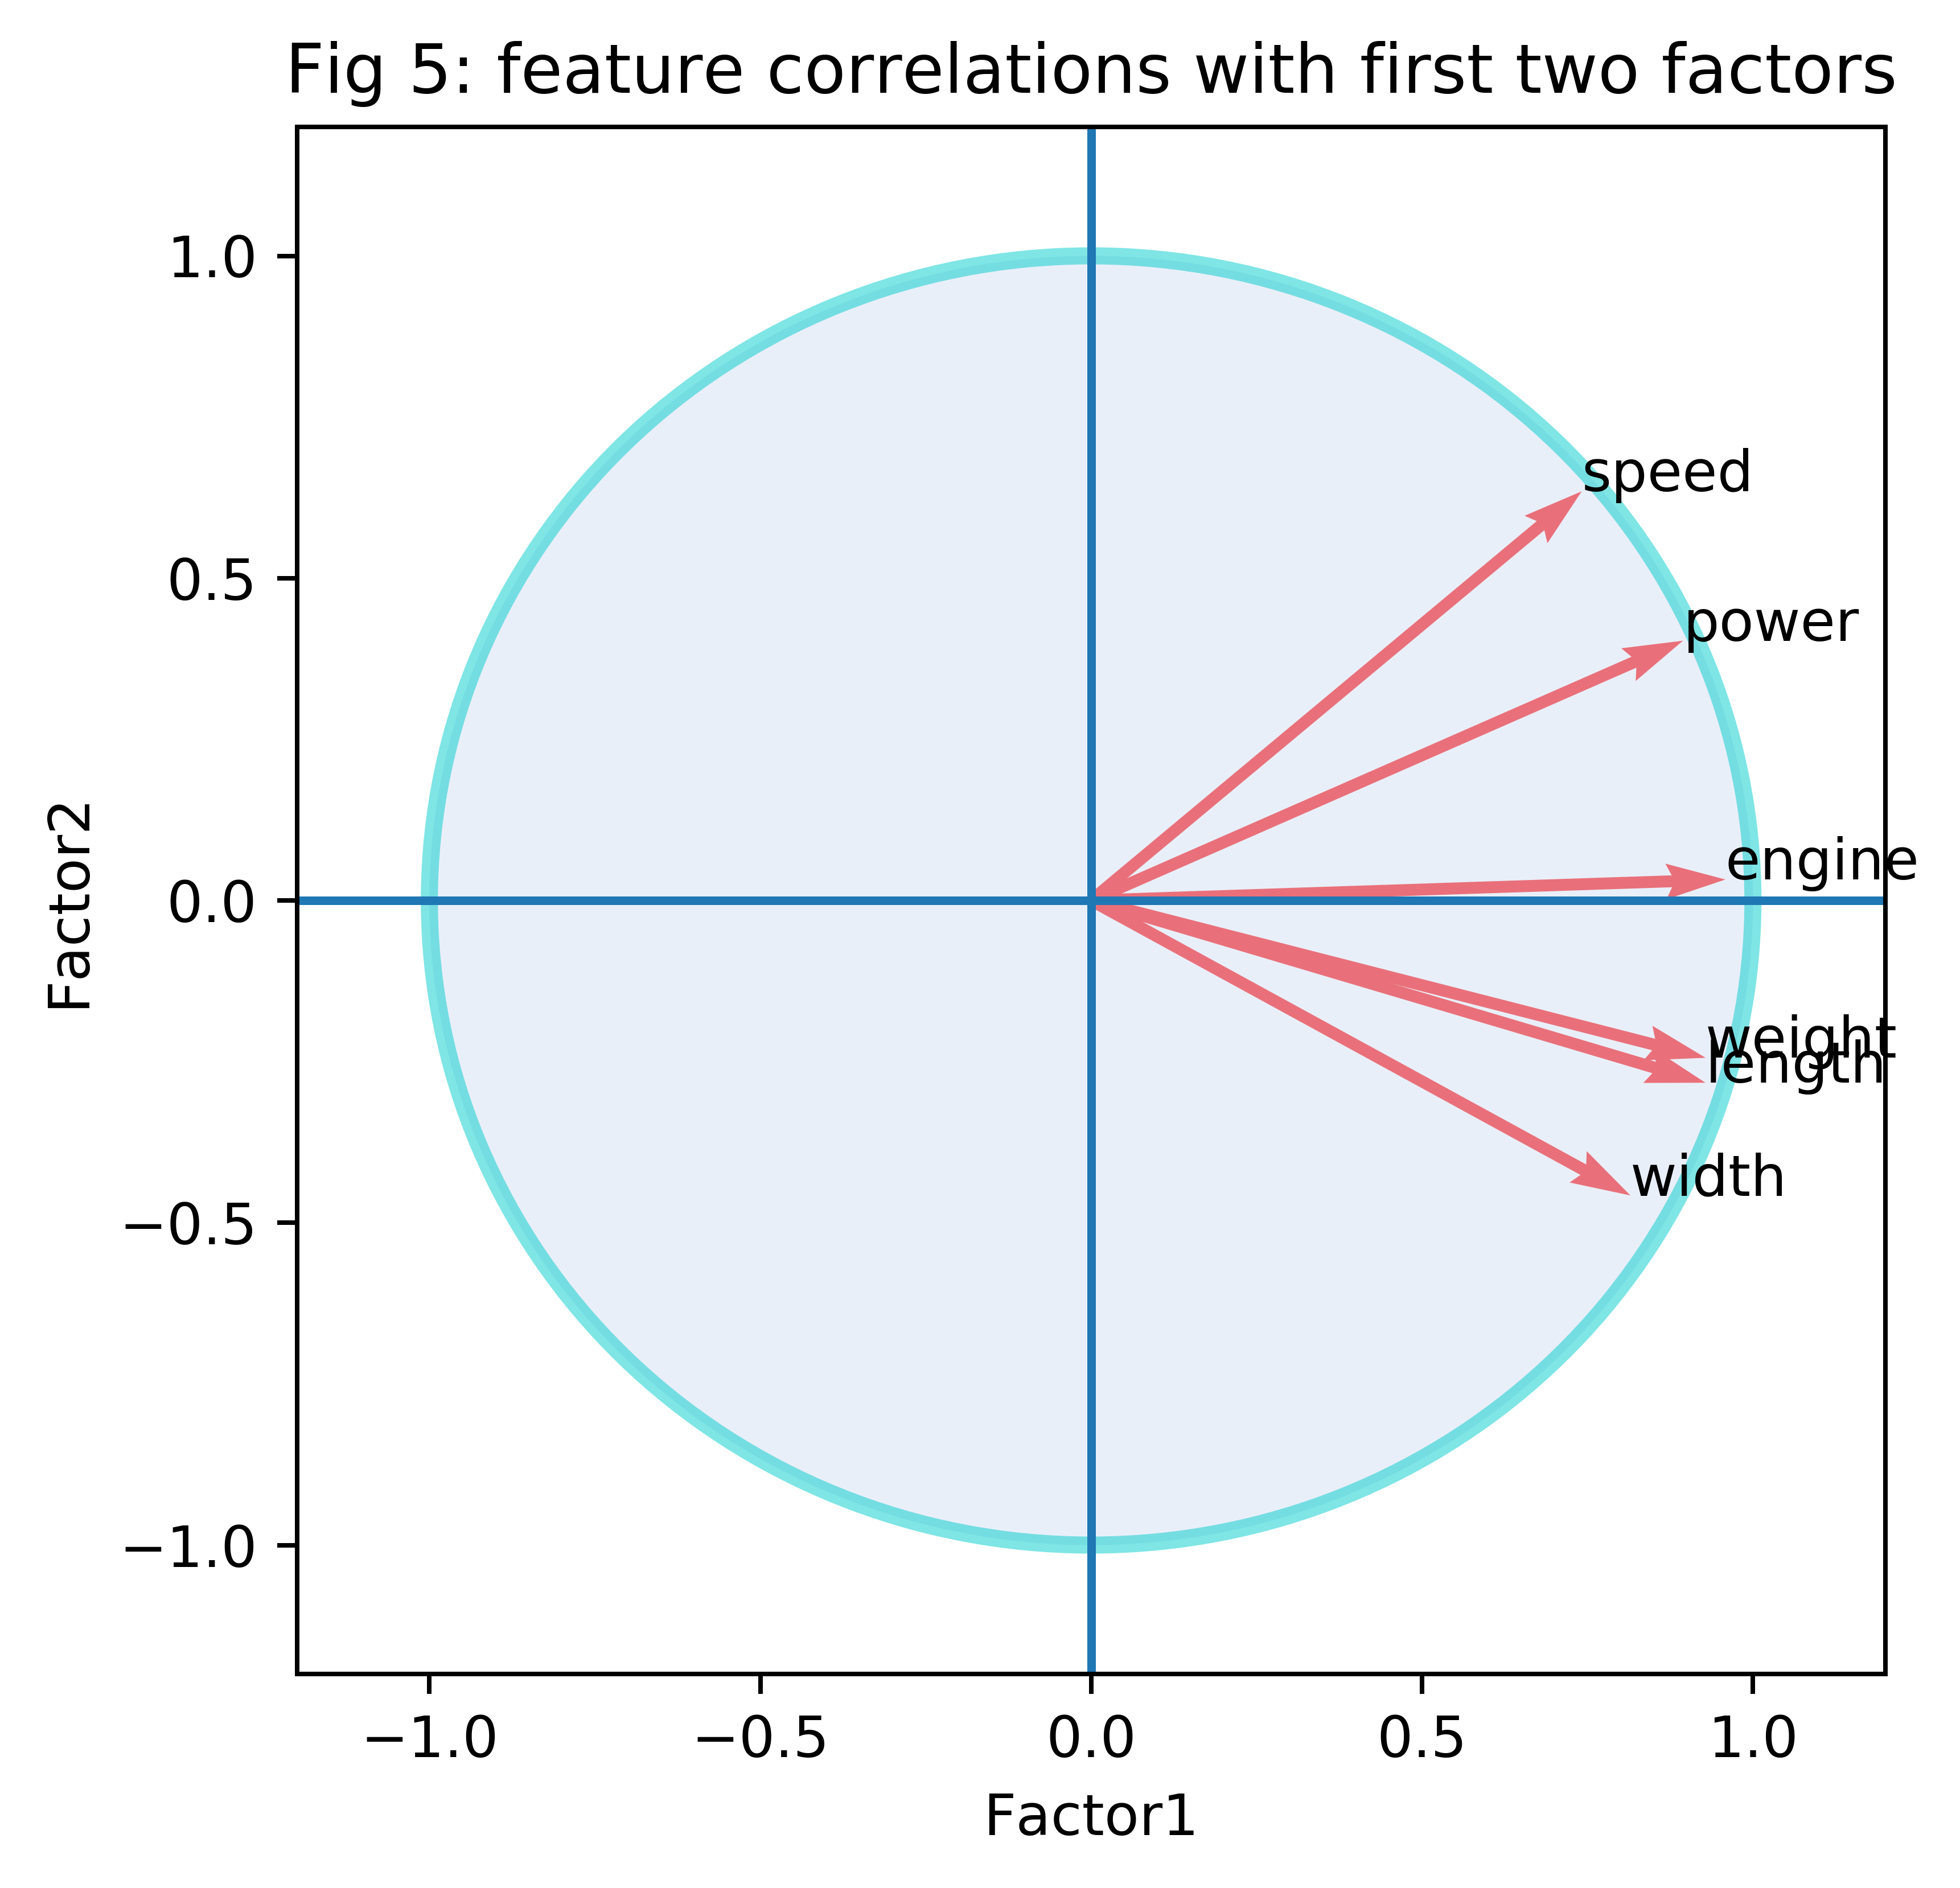

In [26]:
# factor plot
FACTOR_LABELS = ['Factor1', 'Factor2']
FACTOR_INDICES = (0, 1)
from matplotlib.patches import Circle
circle = Circle((0, 0), 1, 
                facecolor='#d4e1f4',
                edgecolor=(0, 0.8, 0.8),
                linewidth=3,
                alpha=0.5)

fig, ax = plt.subplots(figsize=(5, 5))
fig.set_dpi(720)
X, Y = np.zeros(6), np.zeros(6)
U, V = loadings[FACTOR_INDICES[0]], loadings[FACTOR_INDICES[1]]
# ax.scatter(x=loadings[0], y=loadings[1])
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.add_patch(circle)
ax.axhline()
ax.axvline()
ax.quiver(X, Y, U, V, angles='xy', scale_units='xy', scale=1, color='red',
          label=loadings.index)
xy = list(zip(loadings[FACTOR_INDICES[0]], loadings[FACTOR_INDICES[1]]))
labels = list(loadings.index)
_ = [ax.annotate(lab, location) for lab, location in zip(labels, xy)]
ax.set_title('Fig 5: feature correlations with first two factors'.format(
              FACTOR_LABELS[0], FACTOR_LABELS[1]))
ax.set_xlabel(FACTOR_LABELS[0])
ax.set_ylabel(FACTOR_LABELS[1])
# fig.savefig('/home/pieter/Desktop/pca_post/radar_plot.png')

In [27]:
# squared cosines of the variables (= correlations squared)
loadings_squared = loadings**2
loadings_squared

,0,1,2,3,4,5
engine,0.918704,0.001056,0.038745,0.041235,0.000257,0.000002
power,0.799915,0.162386,0.000376,0.006080,0.024632,0.006610
speed,0.549503,0.402833,0.032903,0.000003,0.010511,0.004246
weight,0.862185,0.059591,0.056430,0.014440,0.001558,0.005796
length,0.861734,0.079963,0.000465,0.001781,0.052046,0.004011
width,0.663979,0.209393,0.111511,0.001116,0.013705,0.000296


In [28]:
# Contributions of the variables (%)
100 * loadings_squared.div(loadings_squared.sum())

,0,1,2,3,4,5
engine,19.731536,0.115357,16.114796,63.776264,0.250248,0.011799
power,17.180230,17.742832,0.156505,9.404339,23.982274,31.533820
speed,11.801982,44.014764,13.685190,0.005162,10.234193,20.258708
weight,18.517640,6.511135,23.470211,22.334048,1.516649,27.650316
length,18.507958,8.736993,0.193463,2.754655,50.672854,19.134078
width,14.260654,22.878919,46.379835,1.725533,13.343781,1.411278


In [29]:
# factor scores
standardized2 = (cars - cars.mean()) / cars.std(ddof=0)  # note nr df
fs = standardized2 @ loadings
sd = np.sqrt(loadings_squared.sum())
factors = fs / sd
np.round(factors, 3)

,0,1,2,3,4,5
car,,,,,,
honda civic,-2.023,0.320,0.531,-0.118,0.407,-0.110
renault 19,-0.779,-0.133,0.442,-0.225,-0.213,-0.002
fiat tipo,-1.290,-0.434,0.469,-0.172,0.190,-0.199
peugeot 405,-0.274,-0.465,0.186,0.028,-0.611,-0.028
renault 21,0.181,-0.637,-0.065,-0.328,-0.635,-0.131
citroen bx,-0.505,-0.208,0.151,-0.062,-0.415,-0.175
bmw 530i,3.946,0.835,-0.516,-0.120,0.139,-0.144
rover 827i,3.194,0.771,-0.014,-0.046,-0.008,0.065
renault 25,3.440,0.609,0.628,0.081,0.193,0.041


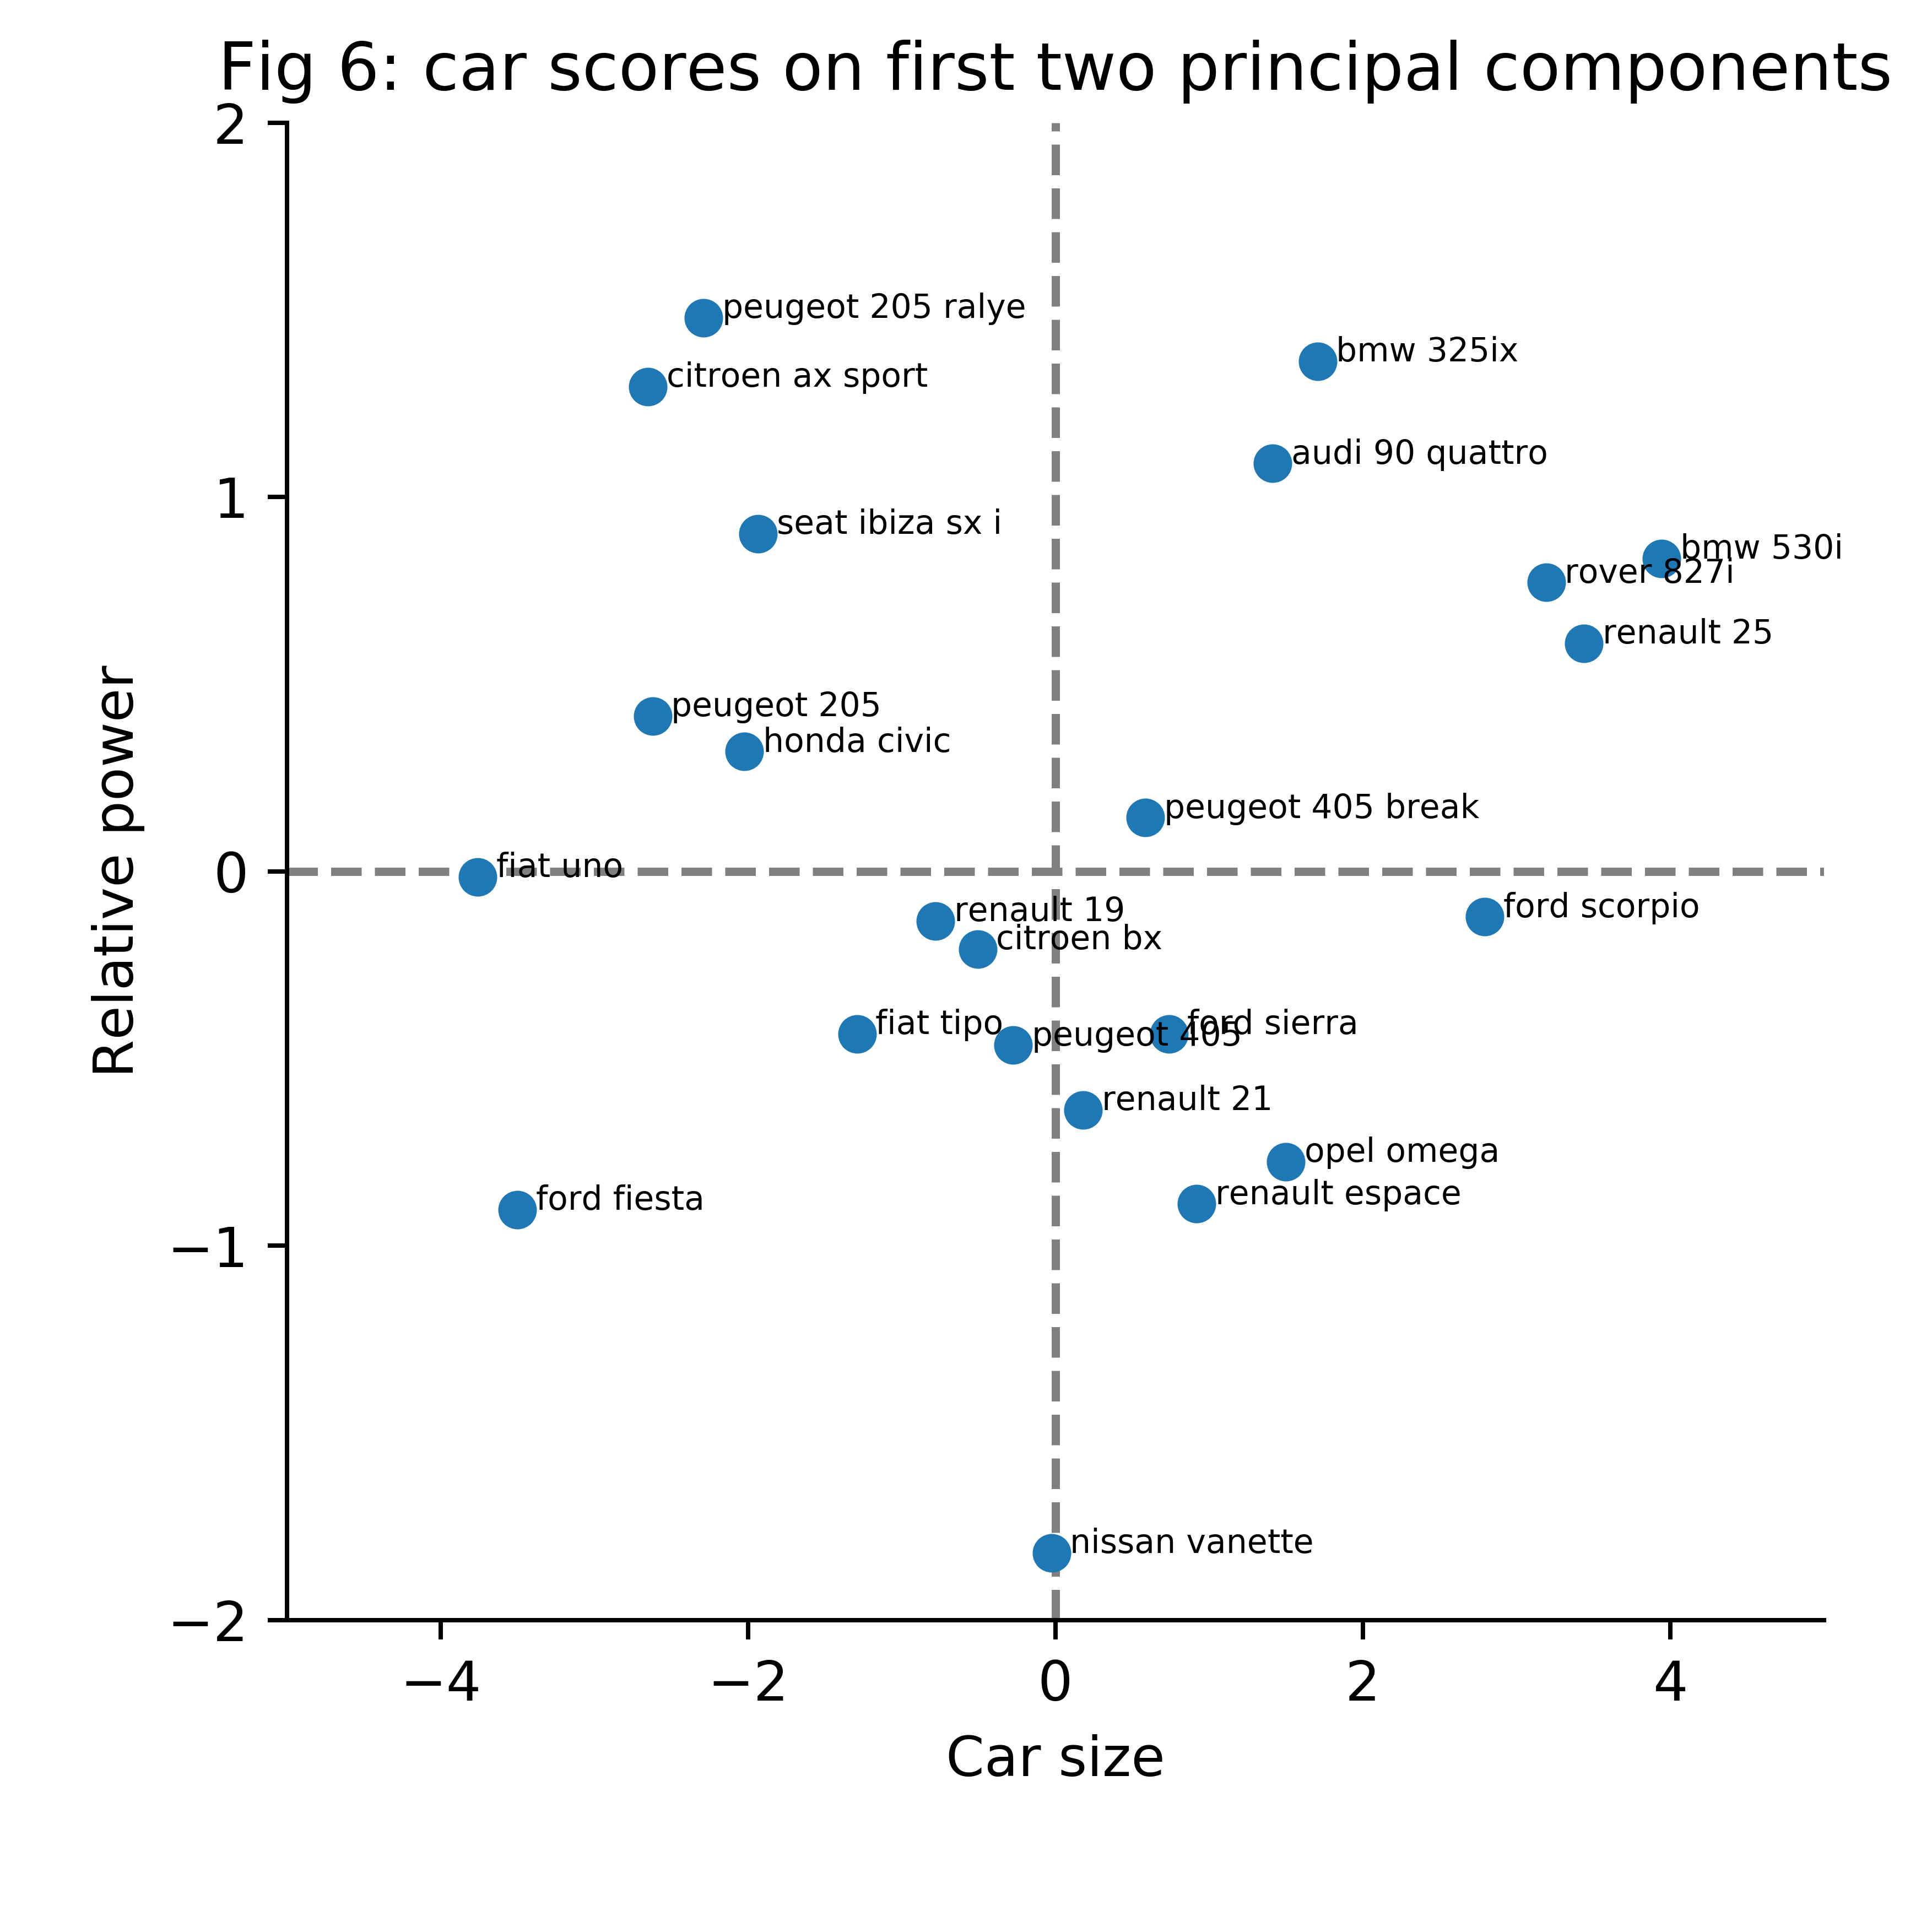

In [30]:
# All samples (cars) with respect to the two main PC directions
fig, ax = plt.subplots(figsize=(5, 5))
fig.set_dpi(720)
ax.scatter(x=factors[0], y=factors[1], marker='o')
labels = factors.index
shift = 0.12
xy = zip(factors[0] + shift, factors[1])
xmin, xmax = (np.ceil(np.min(factors[0])), np.ceil(np.max(factors[0])))
ymin, ymax = (np.ceil(np.min(factors[1])), np.ceil(np.max(factors[1])))
ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))
_ = [ax.annotate(lab, location, size=6) for lab, location in zip(labels, xy)]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim(-5, 5)
ax.yaxis.set_ticks(np.arange(-2, 2+1, 1))
ax.set_xlabel('Car size')
ax.set_ylabel('Relative power')
ax.axhline(0, linestyle='--', color='grey', zorder=-1)
ax.axvline(0, linestyle='--', color='grey', zorder=-1)
ax.set_title('Fig 6: car scores on first two principal components')
# fig.savefig('/home/pieter/Desktop/pca_post/cars_by_2pca.png')